# Opinion detector

**Participants:**
- Roger Baiges Trilla
- Adrià Cantarero Carreras

**Subject:**
- Processament del Llenguatge Humà

**Course:** 2024

**Degree:** Intel·ligència Artificial


## IMPORTS

In [80]:
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string

Necessary functions in order to avoid warnings on MacOS

In [81]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in cast")

In [82]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Downloading the necessary dataset and tools

In [83]:
# Ensure we have the necessary datasets and tools from NLTK
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## PREPROCESSING THE DATASET

In [84]:
# Create a list with all the reviews and their respective categories

documents = [(list(mr.words(fileid)), category)
             for category in mr.categories()
             for fileid in mr.fileids(category)]
data = [' '.join(words) for words, _ in documents]
labels = [category for _, category in documents]

# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# SUPERVISED MODELS

In [85]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))


def preprocessed_data(document):
    """
    Preprocesses a given document by removing numbers, punctuation, converting to lowercase,
    tokenizing, removing stopwords, and lemmatizing the tokens.

    Parameters:
    - document (str): The document to be preprocessed.

    Returns:
    - str: The preprocessed document as a single string.
    """
    # Remove numbers
    document = re.sub(r'\d+', '', document)
    
    # Remove punctuation and convert to lowercase
    document = document.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Tokenize the document
    tokens = word_tokenize(document)
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove stopwords and lemmatize the tokens
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Combine the filtered tokens back into a single string
    return ' '.join(filtered_tokens)

# Apply the improved_preprocess function to the training and testing data
data_train_processed = [preprocessed_data(doc) for doc in X_train]
data_test_processed = [preprocessed_data(doc) for doc in X_test]


In [86]:
# Use CountVectorizer to convert data to a matrix of token counts
vectorizer = CountVectorizer(min_df=5)
data_train_processed = vectorizer.fit_transform(data_train_processed)
data_test_processed = vectorizer.transform(data_test_processed)

### INITIALIZE THE CLASSIFIERS

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


# Initialize the classifiers    
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lr_clf = LogisticRegression(random_state=42)

### SEARCH THE BEST HYPERPARAMETERS WITH CROSS-VALIDATION

In [88]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
}


lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'max_iter': [200, 300, 400]
}


# Map model names to their corresponding grid
param_grid_dict = {
    "Random Forest": rf_param_grid,
    "K-Nearest Neighbors": knn_param_grid,
    "SVM": svm_param_grid,
    "XGBoost": xgb_param_grid,
    "Logistic Regression": lr_param_grid
}

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 


classifiers = {
    "Random Forest": (rf_clf, False),
    "K-Nearest Neighbors": (knn_clf, False),
    "SVM": (svm_clf, False),
    "XGBoost": (xgb_clf, True),
    "Logistic Regression": (lr_clf, False)
}


def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV and cross-validation.

    Parameters:
    - model: The machine learning model to tune.
    - param_grid (dict): The grid of hyperparameters to search.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - The best estimator with optimized hyperparameters.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


# Iterate over each model and tune hyperparameters
for model_name, (model, encode_target) in classifiers.items():
    # If the model requieres label encoding, encode the target labels
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train_encoded)
    else:
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train)
    
    # Update the classifiers dictionary with the best model
    classifiers[model_name] = (best_model, encode_target)


Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'max_depth': 10, 'n_estimators': 200}
Best cross-validation score: 0.8323
Hyperparameter tuning for K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation score: 0.5839
Hyperparameter tuning for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.8292
Hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.8017
Hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'

### EVALUATE MODEL FUNCTION

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

def evaluate_model(model, X_train, X_test, y_train, y_test, encode_target=False):
    """
    Evaluates a given model on test data and returns evaluation metrics.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train, X_test: Training and test features.
    - y_train, y_test: Training and test labels.
    - encode_target (bool): Flag to indicate if the model is XGBoost, requiring label encoding.

    Returns:
    - Tuple of (conf_matrix, accuracy, precision, f1)
    """
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        model.fit(X_train, y_train_encoded)
        predictions_encoded = model.predict(X_test)
        predictions = encoder.inverse_transform(predictions_encoded)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)

    return conf_matrix, accuracy, precision, f1


## TRAIN THE FINAL MODELS

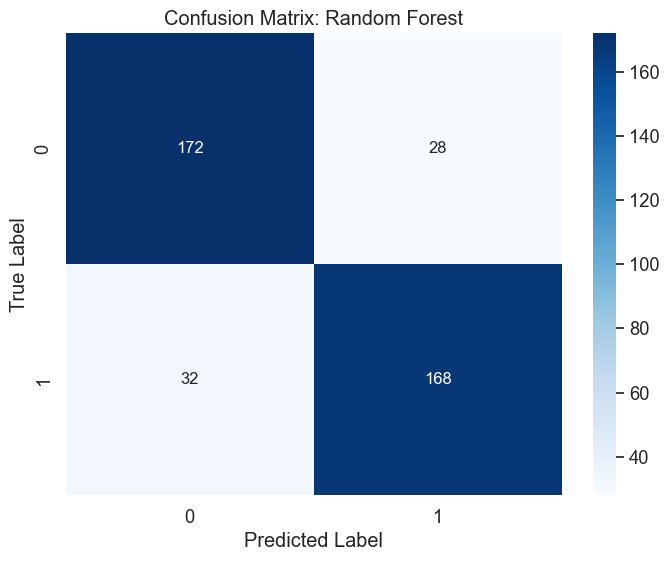

Evaluation Results for Random Forest:
Accuracy: 0.8500, Precision: 0.8501, F1 Score: 0.8500



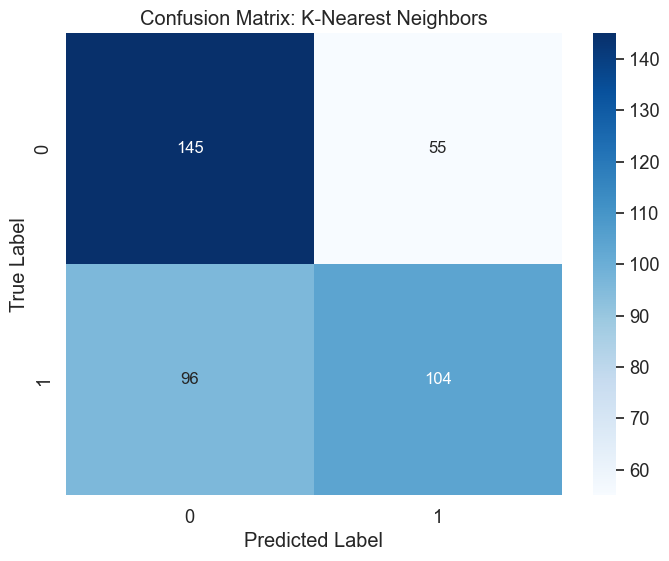

Evaluation Results for K-Nearest Neighbors:
Accuracy: 0.6225, Precision: 0.6279, F1 Score: 0.6185



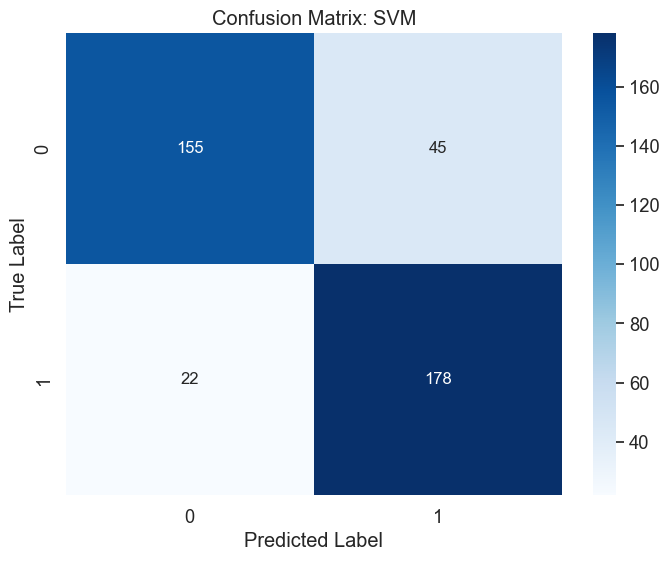

Evaluation Results for SVM:
Accuracy: 0.8325, Precision: 0.8370, F1 Score: 0.8319



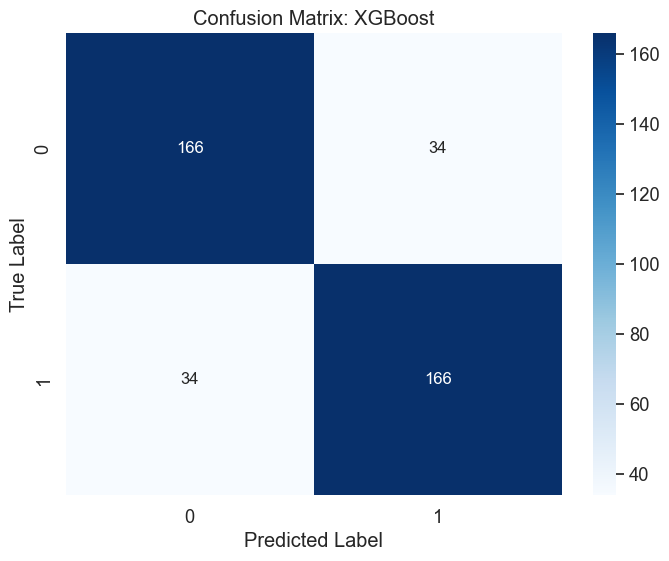

Evaluation Results for XGBoost:
Accuracy: 0.8300, Precision: 0.8300, F1 Score: 0.8300



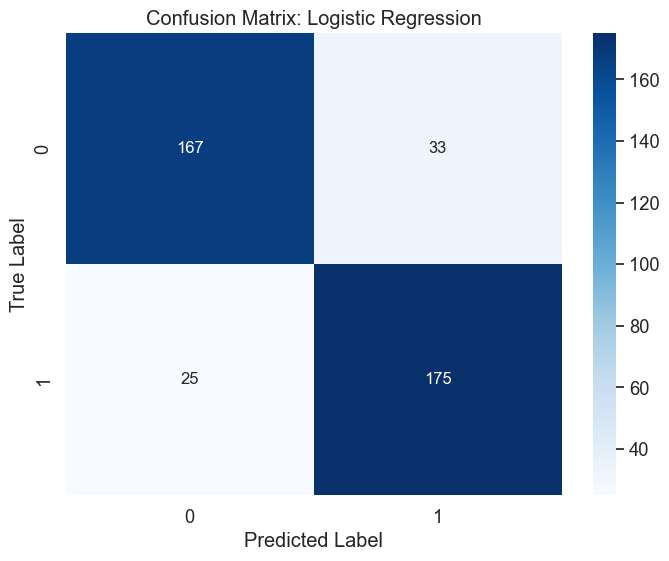

Evaluation Results for Logistic Regression:
Accuracy: 0.8550, Precision: 0.8556, F1 Score: 0.8549



In [91]:
# Iterate over each model and evaluate it on the test data

for model_name, (model, encode_target) in classifiers.items():
    """
    For each model, evaluate it on the test data and display the confusion matrix.
    """
    conf_matrix, accuracy, precision, f1 = evaluate_model(model, data_train_processed, data_test_processed, y_train, y_test, encode_target)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt="g", xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.savefig(f'./images/confusion_matrix_{model_name}.png')
    plt.show()

    # Print evaluation metrics
    print(f"Evaluation Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}\n")

# SENTIMENT ANALYSIS WITH SENTIWORDNET